In [1]:
from constants import *
from phe import best_data
from matplotlib import pyplot as plt
from matplotlib.colors import to_rgba
from matplotlib.patches import ArrowStyle
import pandas as pd

In [2]:
region_data, data_date = best_data(area_type=nhs_region, metrics=(new_admissions, in_hospital, in_mv_beds))
region_admissions = region_data.pivot(index='date', columns='areaName', values=new_admissions)
region_in_hospital = region_data.pivot(index='date', columns='areaName', values=in_hospital)
data_date

datetime.date(2022, 1, 7)

<AxesSubplot:xlabel='date'>

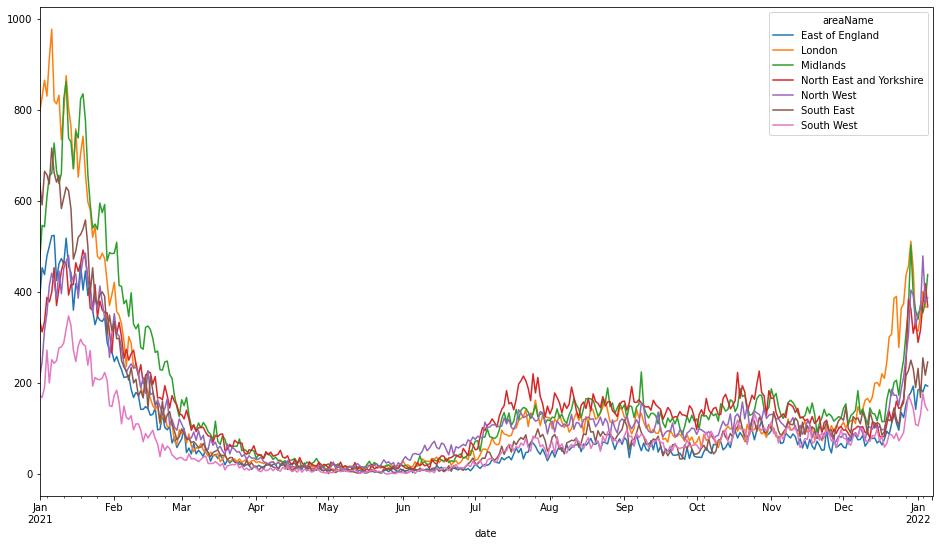

In [3]:
region_admissions.loc['2021':].plot(figsize=(16, 9))

<AxesSubplot:xlabel='date'>

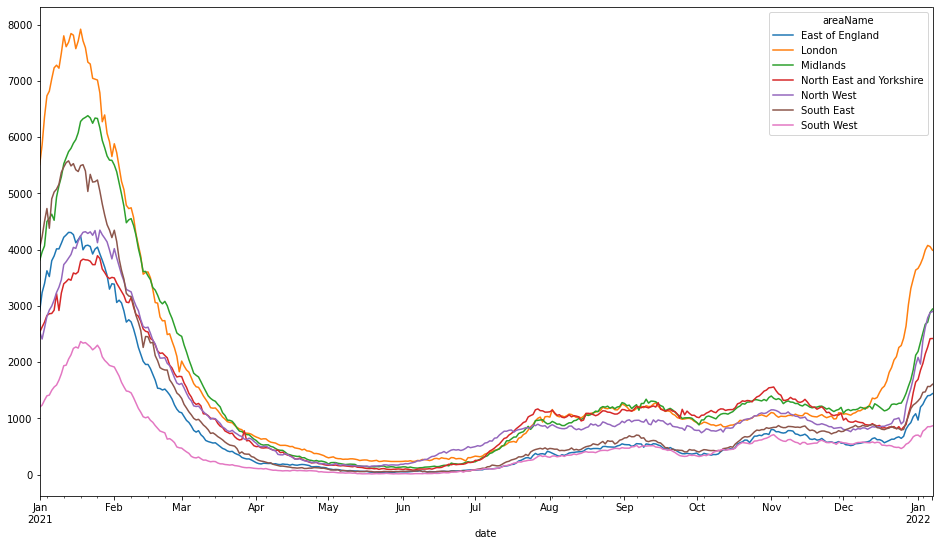

In [4]:
region_in_hospital.loc['2021':].plot(figsize=(16, 9))

In [5]:
region_data, data_date = best_data(area_type=region, metric=new_cases_by_specimen_date)
region_cases = region_data.pivot(index='date', columns='areaName', values=new_cases_by_specimen_date)
data_date

datetime.date(2022, 1, 7)

In [6]:
region = 'London'
london_cases = region_cases[region].rolling(7).mean().rename('Cases by Specimen Date')
london_hospital = region_in_hospital[region].rename('In Hospital')

Text(0.5, 1.0, 'COVID-19 in London')

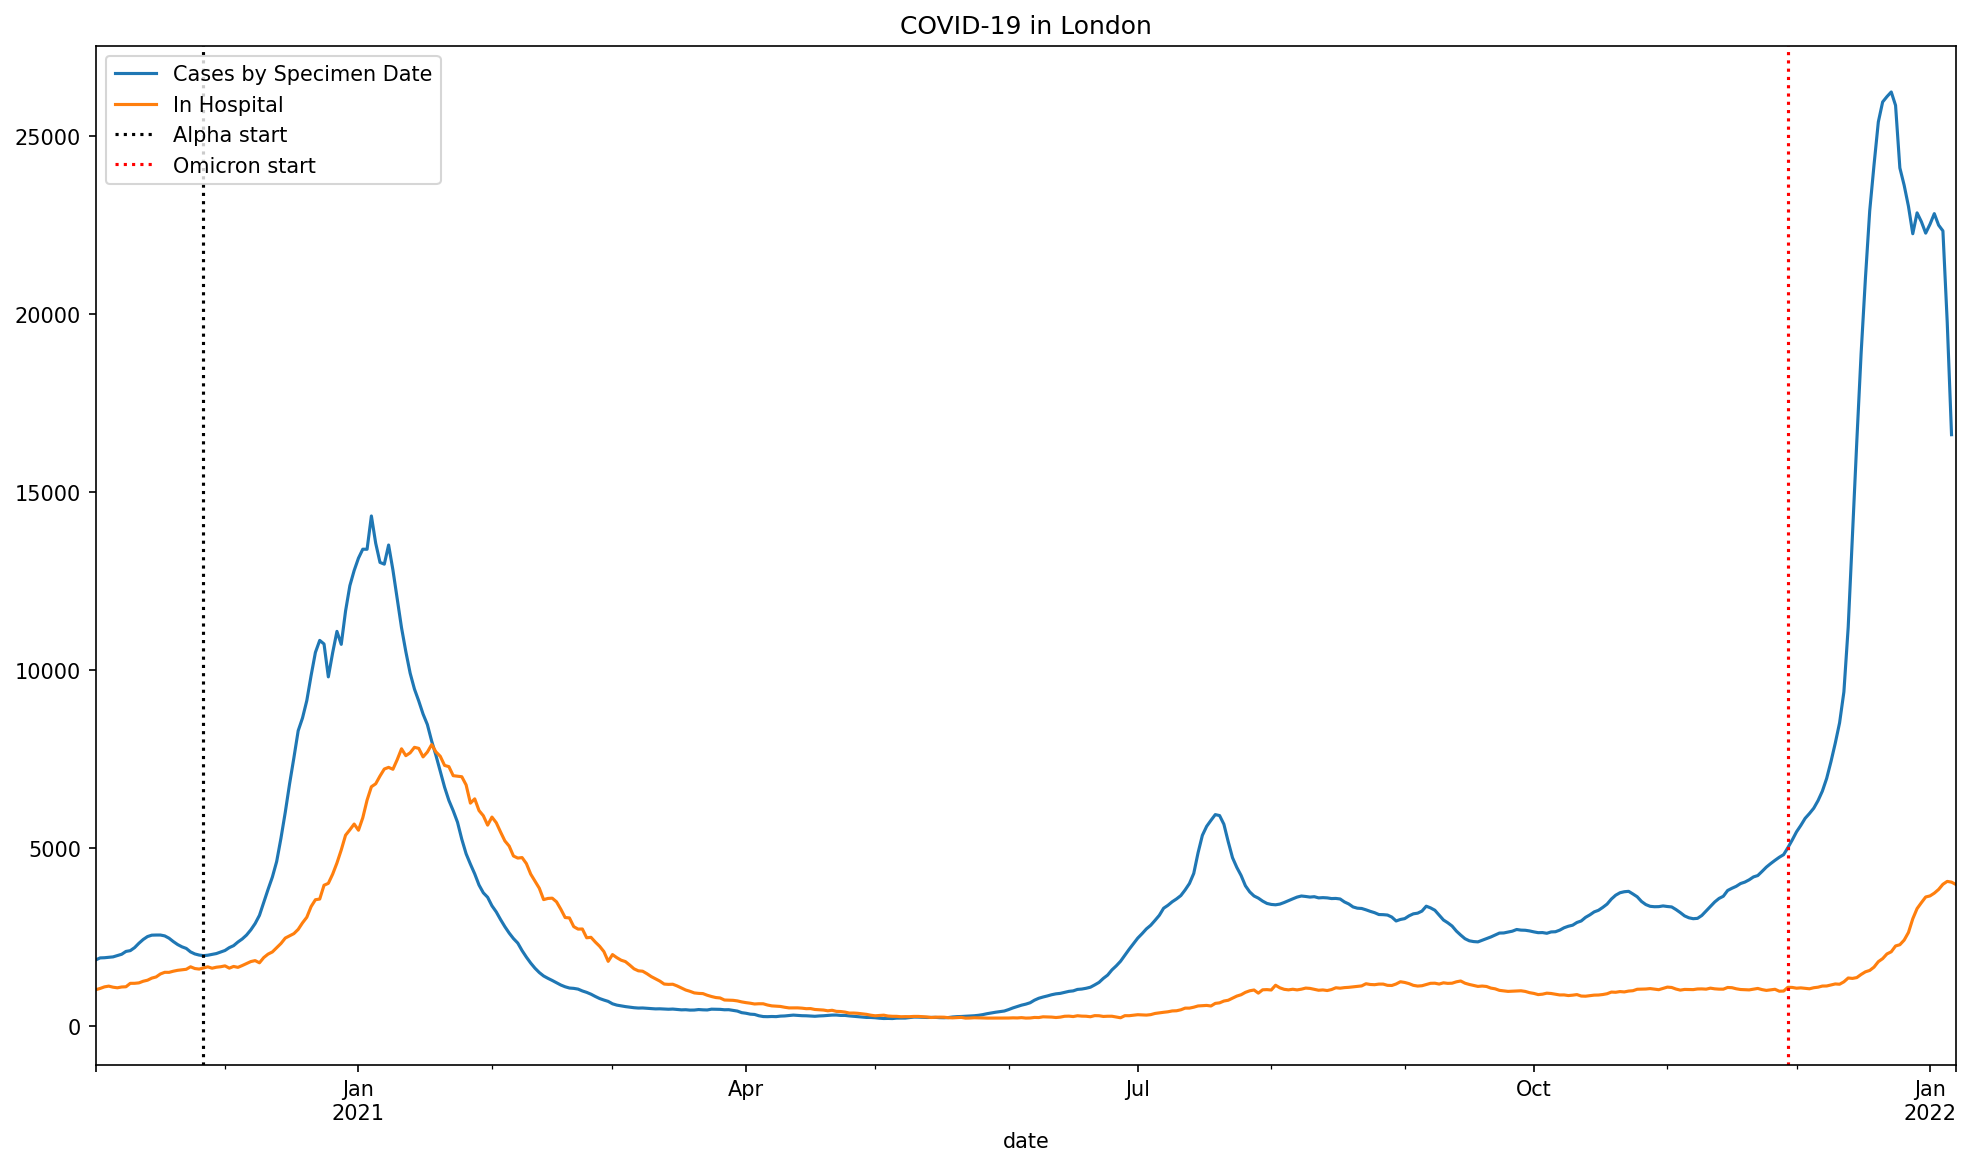

In [7]:
alpha_start = pd.Timestamp('2020-11-26')
omicron_start = pd.Timestamp('2021-11-29')
fig, ax = plt.subplots(figsize=(16, 9), dpi=150)
fig.set_facecolor('white')
london_cases.loc['2020-11-01':].plot(ax=ax, legend=True)
london_hospital.loc['2020-11-01':].plot(ax=ax, legend=True)
ax.axvline(alpha_start, label='Alpha start', color='black', linestyle='dotted')
ax.axvline(omicron_start, label='Omicron start', color='red', linestyle='dotted')
ax.legend(loc='upper left')
ax.set_title(f'COVID-19 in {region}')

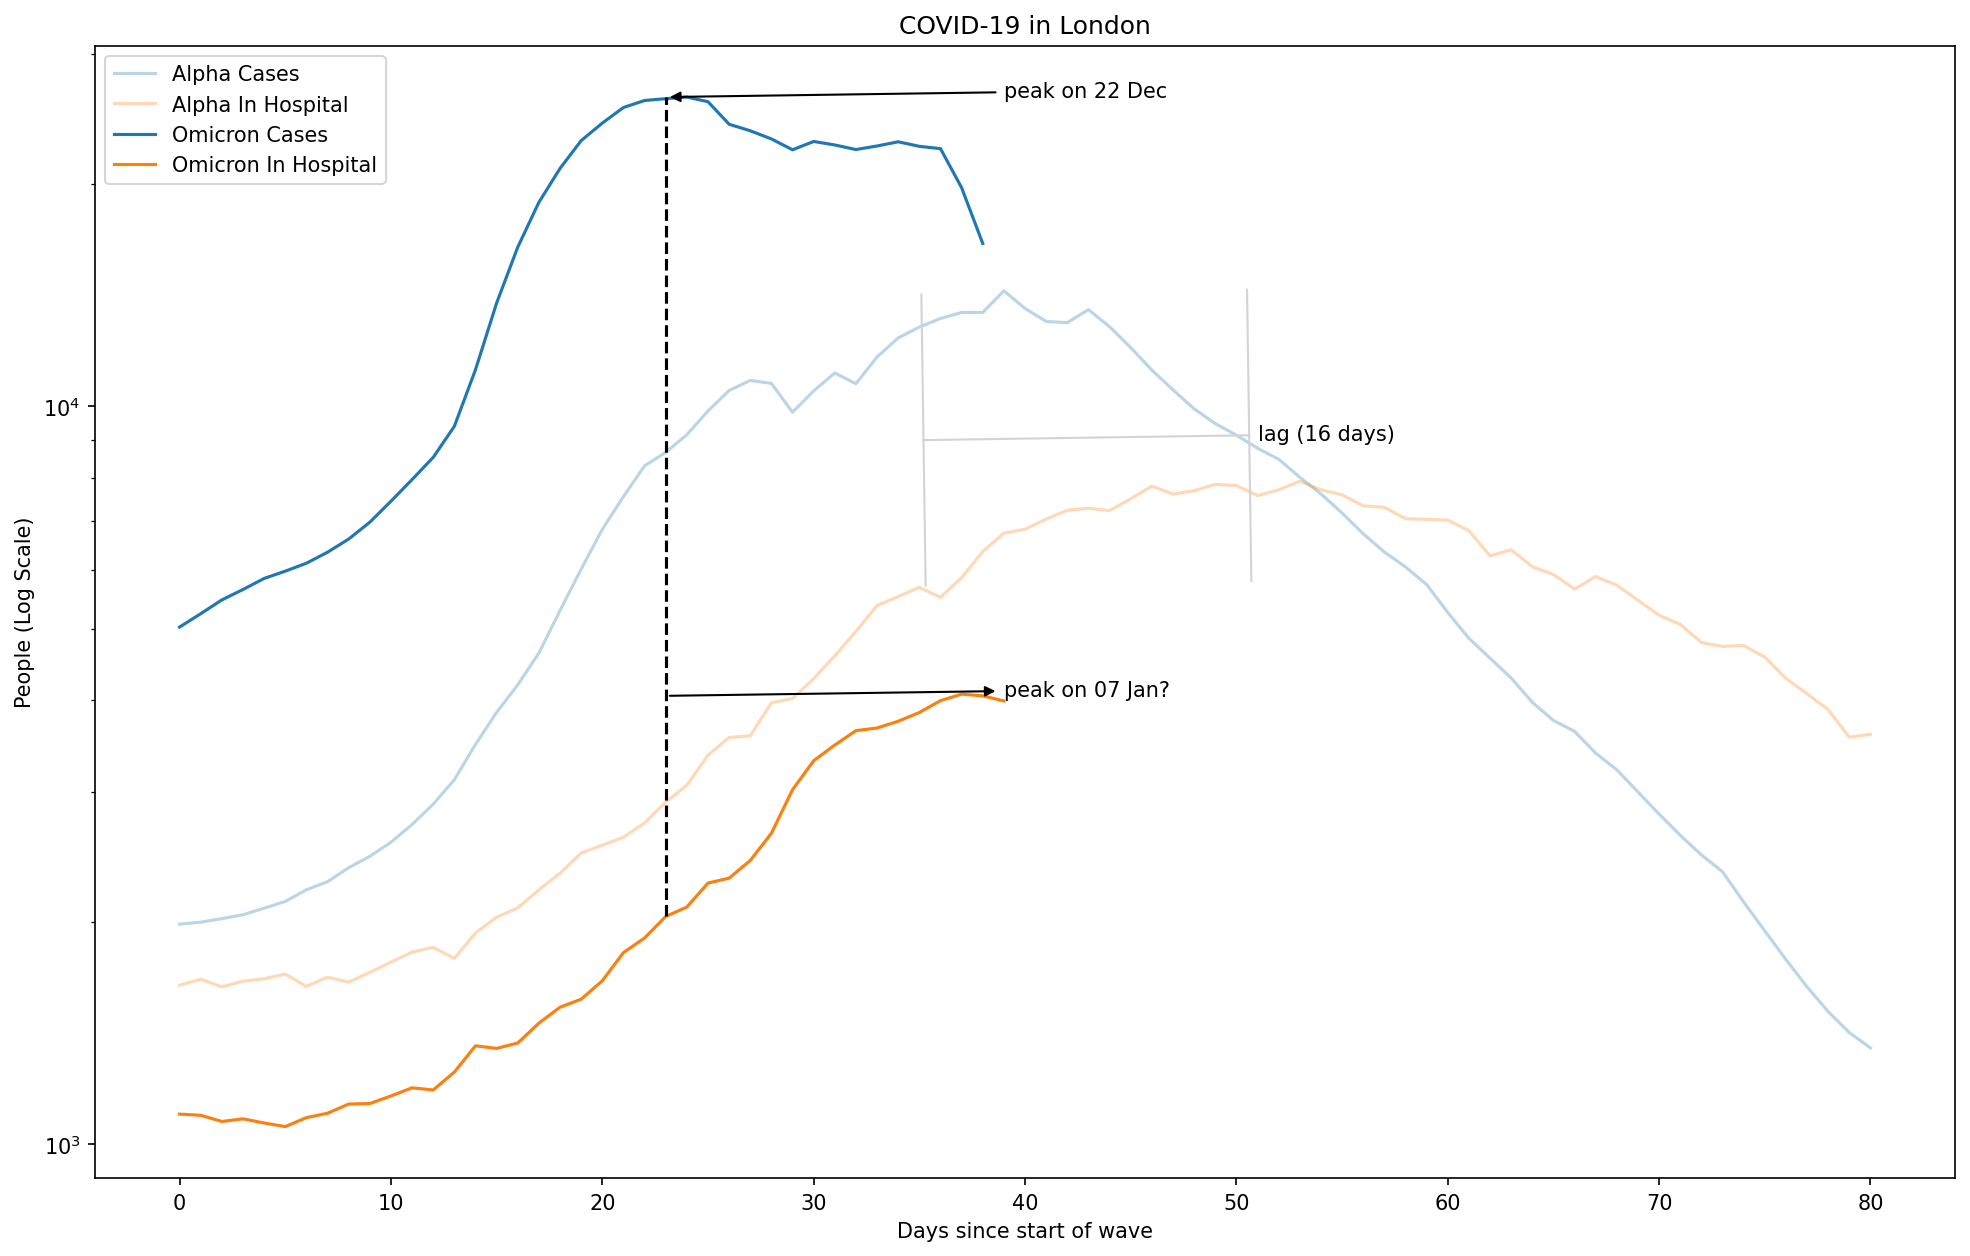

In [8]:
def plot_days_since(ax, data, start, color, label, days=80):
    data = data.copy()
    index = (data.index-start).total_seconds()/60/60/24
    index.name = None
    data.index = index
    data.loc[0:days].plot(ax=ax, color=color, label=label)

def plot_lag(ax, label, x1, x2, *, y, color, arrow):
    ax.annotate(label, xy=(x1, y), xytext=(x2, y), 
                arrowprops=dict(arrowstyle=arrow, color=color))
    
bar = ArrowStyle.BarAB(widthA=7, widthB=7)
arrow_left = ArrowStyle.CurveFilledB()
arrow_right = ArrowStyle.CurveFilledA()

fig, ax = plt.subplots(figsize=(16, 10), dpi=150)
fig.set_facecolor('white')
ax.set_yscale('log')
plot_days_since(ax, london_cases, alpha_start, color=to_rgba('tab:blue', 0.3), label='Alpha Cases')
plot_days_since(ax, london_hospital, alpha_start, color=to_rgba('tab:orange', 0.3), label='Alpha In Hospital')
plot_days_since(ax, london_cases, omicron_start, color='tab:blue', label='Omicron Cases')
plot_days_since(ax, london_hospital, omicron_start, color='tab:orange', label='Omicron In Hospital')
ax.legend(loc='upper left')
plt.xlabel('Days since start of wave')
plt.ylabel('People (Log Scale)')
ax.set_title(f'COVID-19 in London')
x1 = 35
x2 = 51
lag = x2-x1
plot_lag(ax, f'lag ({lag} days)', x1, x2, y=10**4-1000, color='lightgrey', arrow=bar)
omicron_case_peak = 23
omicron_case_peak_dt = omicron_start+pd.Timedelta(days=omicron_case_peak)
omicron_case_peak_label = omicron_case_peak_dt.strftime('peak on %d %b')
x1 = omicron_case_peak
x2 = omicron_case_peak+lag
plot_lag(ax, omicron_case_peak_label, x1, x2, y=london_cases.max(), color='black', arrow=arrow_left)
omicron_hospital_at_case_peak = london_hospital.loc[omicron_case_peak_dt]
omicron_hospital_peak_label = (omicron_case_peak_dt+pd.Timedelta(days=lag)).strftime('peak on %d %b?')
plot_lag(ax, omicron_hospital_peak_label, x1, x2, y=london_hospital.iloc[-2], color='black', arrow=arrow_right)
ax.plot([x1, x1], [omicron_hospital_at_case_peak, london_cases.max()], color='k', linestyle='--')